## Notebook de test - Projet 5 - David Depouez

### 1. Importation et selection

Importation des modules et lecture du fichier de données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
filename = "Cleaned-V3.csv"

Si on fait tourner le modele sur Kaggle

In [3]:
useKaggle = True

In [4]:
if useKaggle == True:
    path = "/kaggle/input/cleaned-v3/"    
else:
    path = "./data/cleaned/"

dfRaw = pd.read_csv(path+filename)

In [5]:
print(dfRaw.shape)
dfRaw.head()

(33573, 5)


,First_tag,Text,Text_lem,Text_lem_length,Text_length
0,javascript,after setting up iis express to recognize json...,setting ii express recognize json file type v ...,64,117
1,javascript,laravel 4 and angular js and twitter bootstrap...,laravel 4 angular j twitter bootstrap 3 pagina...,92,207
2,c#,adding an image to sql database using visual c...,adding image sql database using visual c# work...,76,138
3,php,slim eloquent relation does not work properly ...,slim eloquent relation work properly making cr...,58,113
4,python,how to convert json data into specified pandas...,convert json data specified panda dataframe js...,41,84


In [6]:
dfRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33573 entries, 0 to 33572
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   First_tag        33573 non-null  object
 1   Text             33573 non-null  object
 2   Text_lem         33573 non-null  object
 3   Text_lem_length  33573 non-null  int64 
 4   Text_length      33573 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.3+ MB


Calcul des longueurs maximales en tokens pour les deux types de textes

In [7]:
maxLenLemSentences = dfRaw['Text_lem_length'].max()
print("Max text lem length : ", maxLenLemSentences)
maxLenSentences = dfRaw['Text_length'].max()
print("Max text length : ", maxLenSentences)

Max text lem length :  1581
Max text length :  2387


On fait un Label Encoder sur le tag

In [8]:
le = preprocessing.LabelEncoder()
dfRaw['Labels'] = le.fit_transform(dfRaw['First_tag'])

In [9]:
print(le.classes_)

['android' 'c' 'c#' 'c++' 'ios' 'java' 'javascript' 'php' 'python' 'sql']


In [10]:
dfRaw.head()

,First_tag,Text,Text_lem,Text_lem_length,Text_length,Labels
0,javascript,after setting up iis express to recognize json...,setting ii express recognize json file type v ...,64,117,6
1,javascript,laravel 4 and angular js and twitter bootstrap...,laravel 4 angular j twitter bootstrap 3 pagina...,92,207,6
2,c#,adding an image to sql database using visual c...,adding image sql database using visual c# work...,76,138,2
3,php,slim eloquent relation does not work properly ...,slim eloquent relation work properly making cr...,58,113,7
4,python,how to convert json data into specified pandas...,convert json data specified panda dataframe js...,41,84,8


### 2. Apprentissage non supervisé (LDA)

Génération du sac de mots

In [11]:
feat = 'Text_lem'
cv_min_df = 5
cv_max_df = 1.0

cvect = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df)
cv_transform = cvect.fit_transform(dfRaw[feat])
print(cv_transform.shape)

(33573, 10972)


In [12]:
cvect.get_feature_names_out()

array(['00', '000', '0000', ..., 'zuul', 'zxing', 'zygoteinit'],
      dtype=object)

Modélisation LDA

In [13]:
number_topics = 13

lda = LatentDirichletAllocation(n_components=number_topics, max_iter=5, learning_method = 'online',learning_offset = 50.,
                                random_state = 0,n_jobs = 1).fit(cv_transform)

Fonction d'affichage des Topics

In [14]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

Affichage des Topics

In [15]:
no_top_words = 10
display_topics(lda, cvect.get_feature_names_out(), no_top_words)

Topic 0:
image view size video screen using cell color want model
Topic 1:
function code error get string data using json value return
Topic 2:
application web service xml using app window use project com
Topic 3:
array list value number row want like loop column element
Topic 4:
class object method property date type like map call way
Topic 5:
would data like one way code using use need user
Topic 6:
java android project error server org build app version com
Topic 7:
test spring testing unit run annotation selenium async transaction method
Topic 8:
app io device android game bar node point using play
Topic 9:
page button code form html click user want work javascript
Topic 10:
table database query sql model entity key column db hibernate
Topic 11:
error thread code net run message server application system window
Topic 12:
file php python error using script code work get line


### 3. Apprentissage supervisé

Listes pour stocker les scores de ARI par algorithmes

In [16]:
algoNameList = []
algoAriList = []

#### 3.1 BAG OF WORD (Count Vectorizer)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.linear_model import LogisticRegression
import time

Représentation des taux pour les tags

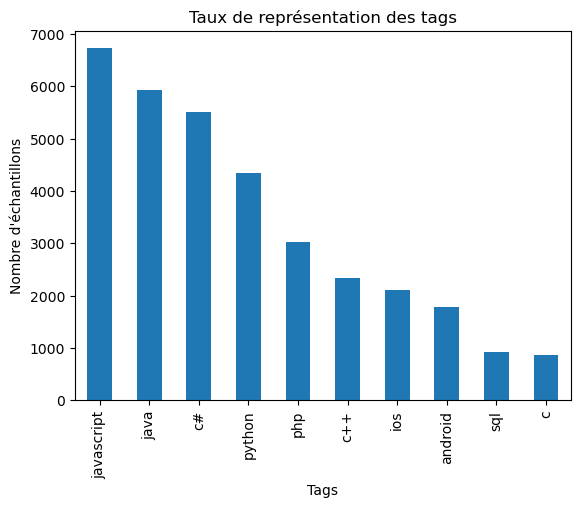

In [18]:
dfRaw['First_tag'].value_counts().plot.bar()
plt.title('Taux de représentation des tags')
plt.xlabel('Tags')
plt.ylabel("Nombre d'échantillons")
plt.show()

Instantiation des modèles

In [19]:
# instantiations
scaler = StandardScaler()
pca = PCA(n_components=0.8)
lr = LogisticRegression(multi_class='ovr', solver='liblinear',class_weight='balanced', penalty='l2',random_state=42)

cv = CountVectorizer()

Fonctions pour les entrainement et test des modèles

In [20]:
# Function to perform scale, pca then logistic regression
def process_log_regression_model(x,y,isfit=False,isScore=True):

    if isfit == True:
        print("Processing Logistic Regression with fit")
        xscaled = scaler.fit_transform(x)
        xreduct = pca.fit_transform(xscaled)
        lr.fit(xreduct, y)
    else:
        print("Processing Logistic Regression")
        xscaled = scaler.transform(x)
        xreduct = pca.transform(xscaled)
    
    ypred = lr.predict(xreduct)
    if isScore == True:
        score = np.round(lr.score(xreduct,y),2)
    else:
        score = 0
        
    return xreduct, ypred, score

# Function to test a model previously trained
def test_model(xtest, ytest):
    
    # prediction on test set
    x, ypred, testScore = process_log_regression_model(xtest,ytest)
    # compute ari score for test set    
    ari = np.round(adjusted_rand_score(ytest, ypred),4)
    
    print("Scores : ARI {}, Accuracy on Data {}".format(ari,testScore))
    
    return x, ypred, ari, testScore

# Function to train and test models
def train_and_test_model(xtrain, ytrain, xtest, ytest):
    
    # fit model on train set
    x, ypred, trainScore = process_log_regression_model(xtrain,ytrain,isfit=True)
    # prediction on test set
    x, ypred, testScore = process_log_regression_model(xtest,ytest)
    # compute ari score for test set    
    ari = np.round(adjusted_rand_score(ytest, ypred),4)
    
    print("Scores : ARI {}, Accuracy on Train {}, Accuracy on Test {}".format(ari, trainScore,testScore))
    
    return x, ypred, ari, trainScore, testScore

Fonction de génération d'un dataframe pour BOW en fonction des limites choisies

In [21]:
def bow_gen_df(dFrame,min_df,max_df=0.95):

    cv.set_params(min_df=min_df,max_df=max_df)
    cv_transform = cv.fit_transform(dFrame['Text_lem'])
    count_array = cv_transform.toarray()
    df = pd.DataFrame(data=count_array,columns = cv.get_feature_names_out())
    df['Labels'] = dFrame['Labels']
    return df

Fonction d'affichage des labels vrais, des labels prédits et du score de ARI

In [22]:
def view_fct(X, trueLabels, predictLabels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X[:,0],X[:,1], c=trueLabels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=list(le.classes_), loc="best", title="Categorie")
    plt.title('Représentation des posts par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X[:,0],X[:,1], c=predictLabels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=list(le.classes_), loc="best", title="Categorie")
    plt.title('Représentation des posts par prédiction')
    
    plt.show()
    print("ARI : ", ARI)    

In [23]:
def view_3Dfct(X, trueLabels, predictLabels, ARI) :    
    alpha = 0.6
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121,projection='3d')
    scatter = ax.scatter(X[:,0],X[:,1],X[:,2], c=trueLabels, cmap='Set1',alpha=alpha)
    ax.legend(handles=scatter.legend_elements()[0], labels=list(le.classes_), loc="best", title="Categorie")
    plt.title('Représentation des posts par catégories réelles')
    
    ax = fig.add_subplot(122,projection='3d')
    scatter = ax.scatter(X[:,0],X[:,1],X[:,2], c=predictLabels, cmap='Set1',alpha=alpha)
    ax.legend(handles=scatter.legend_elements()[0], labels=list(le.classes_), loc="best", title="Categorie")
    plt.title('Représentation des posts par prédiction')
    
    plt.show()
    print("ARI : ", ARI)    

Préparation du dataframe avec les features pertinentes uniquement

In [24]:
dfReduct = dfRaw.drop(columns=['First_tag','Text','Text_lem_length'], axis=1)
print(dfReduct.shape)
dfReduct.head()

(33573, 3)


,Text_lem,Text_length,Labels
0,setting ii express recognize json file type v ...,117,6
1,laravel 4 angular j twitter bootstrap 3 pagina...,207,6
2,adding image sql database using visual c# work...,138,2
3,slim eloquent relation work properly making cr...,113,7
4,convert json data specified panda dataframe js...,84,8


BOF pour differents parametres de min_df

In [25]:
min_df_list = [500,200,100,80,60,40,20]
#min_df_list = [500,200]
max_df = 0.95

bestAri = []
for mindf in min_df_list:
    print("Processing CountVectorizer for min_df = ",mindf)
    # create Bag Of Word 
    df = bow_gen_df(dfReduct,mindf)
    
    # split df dataframe into training, and test sets dataframes
    training_set, test_set = train_test_split(df,test_size=0.2,stratify=df['Labels'],random_state=42)
    xtrain, xval, ytrain, yval = train_test_split(training_set.drop(columns='Labels',axis=1),training_set['Labels'],test_size=0.2,stratify=training_set['Labels'],random_state=42)
    print("Train_and_test_model...")
    x, ypred, ari, trainScore, valScore = train_and_test_model(xtrain, ytrain, xval, yval)
    bestAri.append(ari)
    #print("Scores : ARI {} Train {} Val {}".format(ari, trainScore,valScore))

bestAriIndex = bestAri.index(max(bestAri))
best_min_df = min_df_list[bestAriIndex]
print("\nBest Ari = {} found for min_df = {}".format(max(bestAri),best_min_df))

# fit on training and predict on test
print("Processing CountVectorizer with best_min_df found = ",best_min_df)
df = bow_gen_df(dfReduct,best_min_df)
# split df dataframe into training, and test sets dataframes
training_set, test_set = train_test_split(df,test_size=0.2,stratify=df['Labels'],random_state=42)

xtraining = training_set.drop(columns='Labels',axis=1)
xtest = test_set.drop(columns='Labels',axis=1)
ytraining = training_set['Labels']
ytest = test_set['Labels']

print("Train_and_test_model ...")
x, ypred, ari, trainingScore, testScore = train_and_test_model(xtraining, ytraining, xtest, ytest)
#print("Scores : ARI {} Train {} Val {}".format(ari, trainingScore,testScore))

# store algo name and ari score obtained for the test_set
algoNameList.append("Bag of Word")
algoAriList.append(ari)

Processing CountVectorizer for min_df =  500
Train_and_test_model...
Processing Logistic Regression with fit
Processing Logistic Regression
Scores : ARI 0.2756, Accuracy on Train 0.61, Accuracy on Test 0.55
Processing CountVectorizer for min_df =  200
Train_and_test_model...
Processing Logistic Regression with fit
Processing Logistic Regression
Scores : ARI 0.3612, Accuracy on Train 0.73, Accuracy on Test 0.62
Processing CountVectorizer for min_df =  100
Train_and_test_model...
Processing Logistic Regression with fit
Processing Logistic Regression
Scores : ARI 0.3875, Accuracy on Train 0.79, Accuracy on Test 0.64
Processing CountVectorizer for min_df =  80
Train_and_test_model...
Processing Logistic Regression with fit
Processing Logistic Regression
Scores : ARI 0.3803, Accuracy on Train 0.81, Accuracy on Test 0.64
Processing CountVectorizer for min_df =  60
Train_and_test_model...
Processing Logistic Regression with fit
Processing Logistic Regression
Scores : ARI 0.3856, Accuracy on T

Score de ARI en fonction de min_df

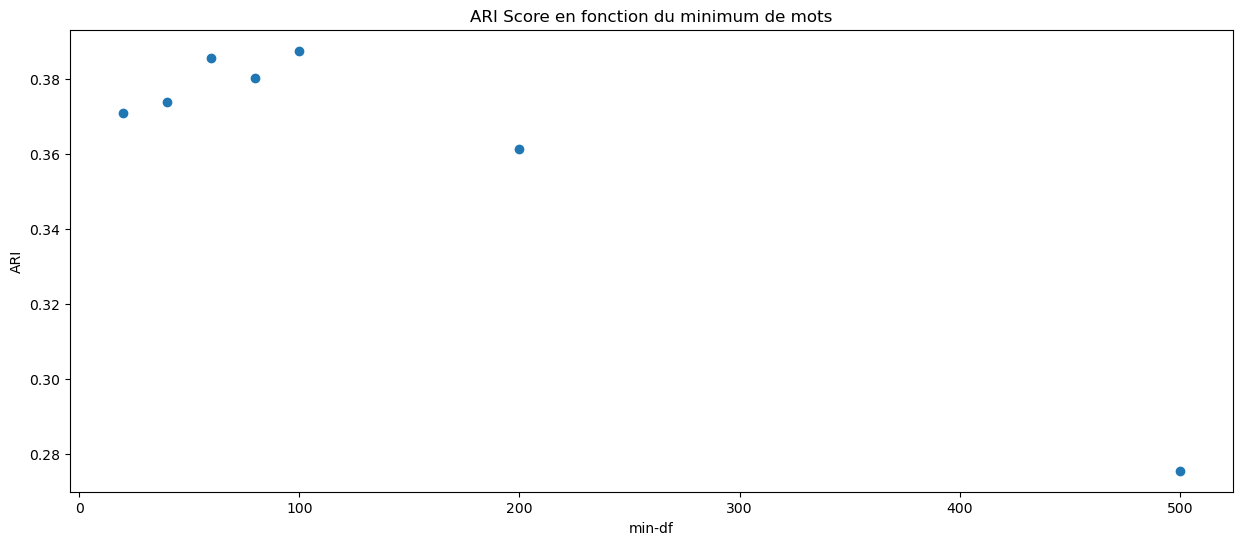

In [26]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(111)
scatter = ax.scatter(min_df_list,bestAri)
#ax.legend(handles=scatter.legend_elements()[0], labels=labels_cat, loc="best", title="Categorie")
plt.xlabel('min-df')
plt.ylabel('ARI')
plt.title('ARI Score en fonction du minimum de mots')

plt.show()

On test le modele entrainé sur toutes les datas pour visualisation

In [27]:
# for visualisation of all data with the model previously trained
print("Test_model on all data ...")
x, ypred, ari, testScore = test_model(df.drop(columns='Labels',axis=1), df['Labels'])

Test_model on all data ...
Processing Logistic Regression
Scores : ARI 0.5259, Accuracy on Data 0.75


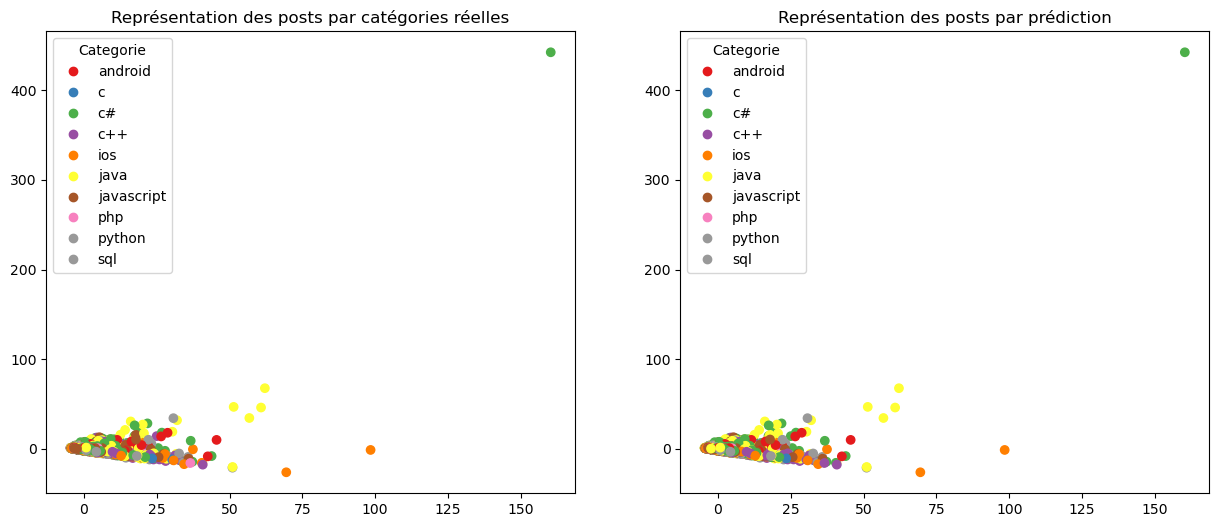

ARI :  0.5259


In [28]:
view_fct(x, df['Labels'], ypred, ari)

#### 3.2 WORD2VECT

In [29]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [30]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = maxLenLemSentences # adapt to length of sentences
sentences = dfRaw['Text_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [31]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 53092
Word2Vec trained


In [32]:
len(model_vectors),len(model_vectors[0])

(53092, 300)

In [33]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 53093


In [34]:
x_sentences.shape

(33573, 1581)

In [35]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (53093, 300)


In [36]:
embedding_matrix.shape

(53093, 300)

In [37]:
# Création du modèle

#input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1581)]            0         
                                                                 
 embedding (Embedding)       (None, 1581, 300)         15927900  
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 15,927,900
Trainable params: 15,927,900
Non-trainable params: 0
_________________________________________________________________


In [38]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

1050/1050 [==============================] - 34s 32ms/step


(33573, 300)

Séparation des datas en deux ensembles

In [39]:
xtrain, xtest, ytrain, ytest = train_test_split(embeddings,dfRaw['Labels'],test_size=0.2,stratify=dfRaw['Labels'],random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((26858, 300), (6715, 300), (26858,), (6715,))

Entrainement et test

In [40]:
print("Train_and_test_model ...")
x, ypred, ari, trainingScore, testScore = train_and_test_model(xtrain, ytrain, xtest, ytest)

Train_and_test_model ...
Processing Logistic Regression with fit
Processing Logistic Regression
Scores : ARI 0.4608, Accuracy on Train 0.69, Accuracy on Test 0.69


In [41]:
# store algo name and ari score obtained for the test_set
algoNameList.append("Word2Vect")
algoAriList.append(ari)

Visualisation

In [42]:
# now use model to predict on all data
print("Test_model on all data...")
x, ypred, ari, testScore = test_model(embeddings, dfRaw['Labels'])

Test_model on all data...
Processing Logistic Regression
Scores : ARI 0.4638, Accuracy on Data 0.69


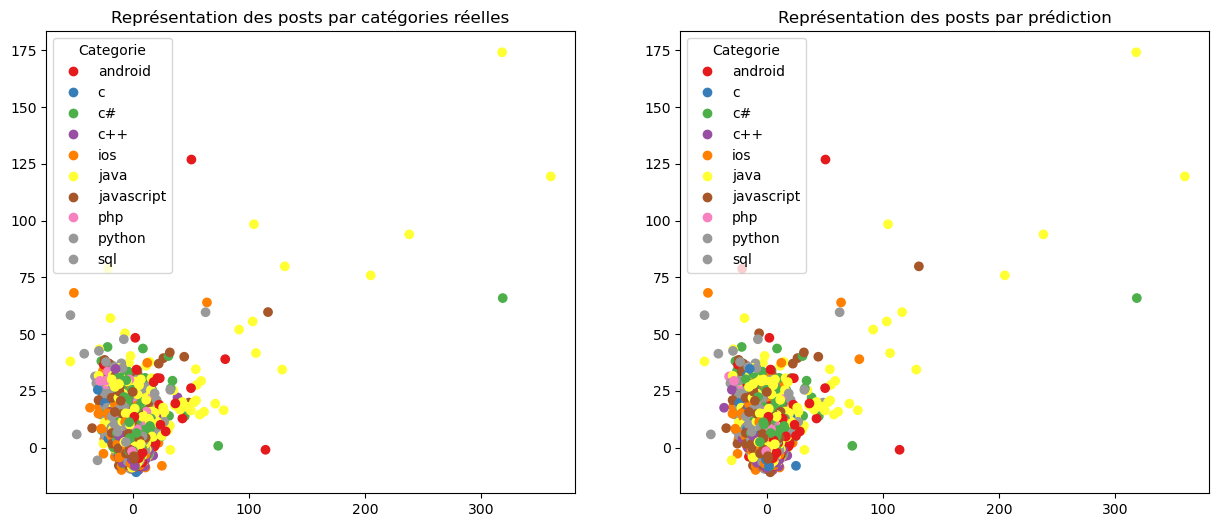

ARI :  0.4638


In [43]:
view_fct(x, dfRaw['Labels'], ypred, ari)

#### 3.3 USE

In [44]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [45]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

Preparation ses sentences et batch de 19 pour l'entrainement

In [46]:
batch_size = 19
sentences = dfRaw['Text'].to_list()

application du modèle USE sur les entrées

In [47]:
features_USE = feature_USE_fct(sentences, batch_size)

In [48]:
features_USE.shape

(33573, 512)

Split des entrées

In [49]:
xtrain, xtest, ytrain, ytest = train_test_split(features_USE,dfRaw['Labels'],test_size=0.2,stratify=dfRaw['Labels'],random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((26858, 512), (6715, 512), (26858,), (6715,))

Entrainement et test des modèles de classification

In [50]:
print("Train_and_test_model ...")
x, ypred, ari, trainingScore, testScore = train_and_test_model(xtrain, ytrain, xtest, ytest)

Train_and_test_model ...
Processing Logistic Regression with fit
Processing Logistic Regression
Scores : ARI 0.6196, Accuracy on Train 0.81, Accuracy on Test 0.79


In [51]:
# store algo results on text
algoNameList.append("USE")
algoAriList.append(ari)

Visualisation

In [52]:
# now use model to predict on all data 
print("Test_model on all data ...")
x, ypred, ari, testScore = test_model(features_USE, dfRaw['Labels'])

Test_model on all data ...
Processing Logistic Regression
Scores : ARI 0.6332, Accuracy on Data 0.81


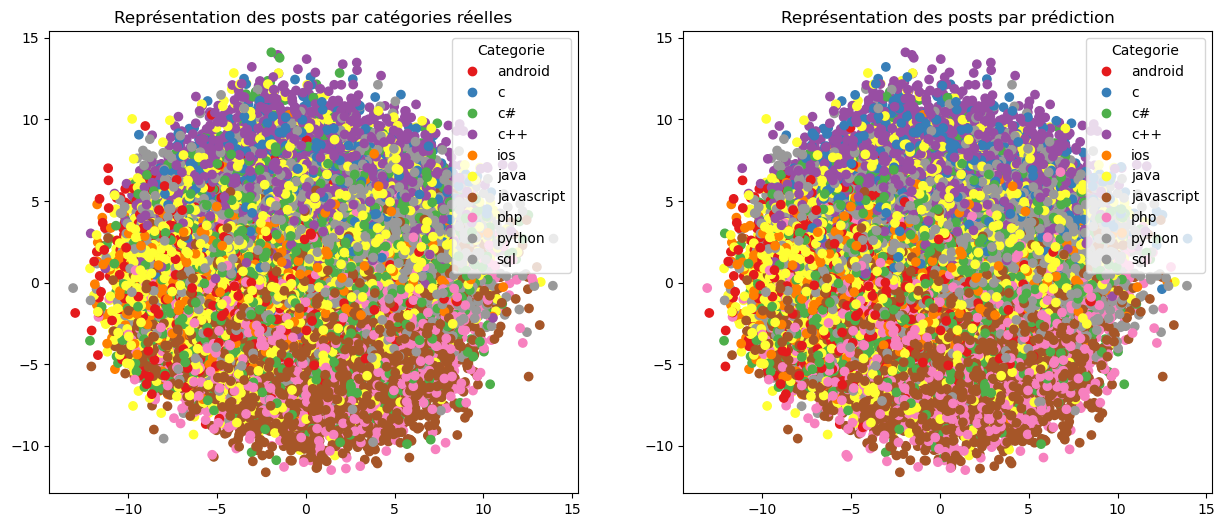

ARI :  0.6332


In [53]:
view_fct(x, dfRaw['Labels'], ypred, ari)

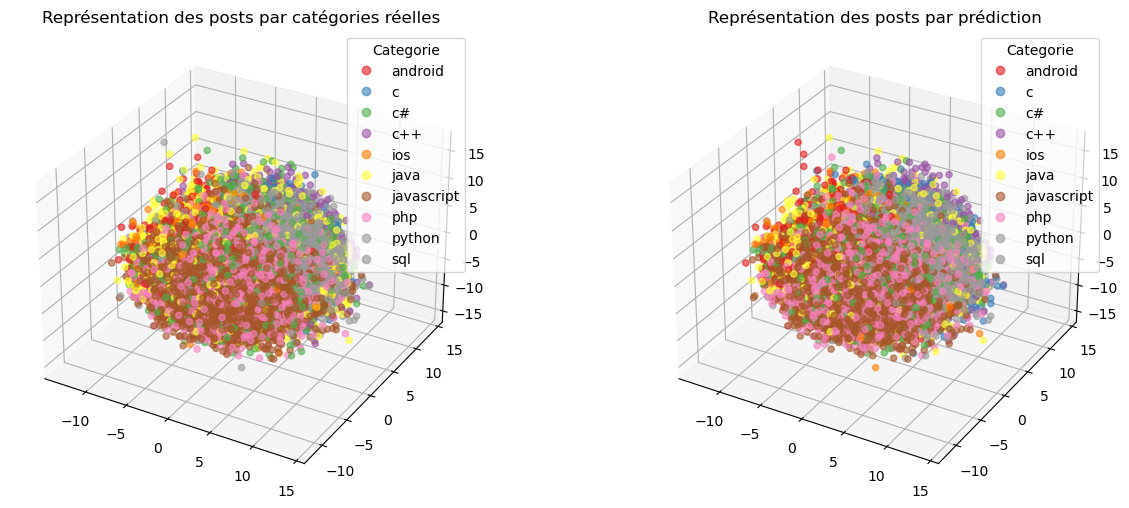

ARI :  0.6332


In [54]:
view_3Dfct(x, dfRaw['Labels'], ypred, ari)

#### 3.4 BERT

In [55]:
# Bert
import os
import transformers
#from transformers import *

os.environ["TF_KERAS"]='1'

In [56]:
import tensorflow_hub as hub
import tensorflow_text 

#from transformers import *
from transformers import AutoTokenizer, TFAutoModel

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [57]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
True


In [58]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

Géneration des sentences

In [59]:
sentences = dfRaw['Text'].to_list()

Application du modèle sur les entrées

In [60]:
max_length = 64
batch_size = 19
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  7263.0


In [61]:
features_bert.shape

(33573, 768)

Split des datas

In [62]:
xtrain, xtest, ytrain, ytest = train_test_split(features_bert,dfRaw['Labels'],test_size=0.2,stratify=dfRaw['Labels'],random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((26858, 768), (6715, 768), (26858,), (6715,))

Entrainement et test des modèles de classification

In [63]:
print("Train_and_test_model ...")
x, ypred, ari, trainingScore, testScore = train_and_test_model(xtrain, ytrain, xtest, ytest)

Train_and_test_model ...
Processing Logistic Regression with fit
Processing Logistic Regression
Scores : ARI 0.1712, Accuracy on Train 0.48, Accuracy on Test 0.47


In [64]:
# store algo results on text
algoNameList.append("BERT")
algoAriList.append(ari)

Visualisation

In [65]:
# now use model to predict on all data 
print("Test_model on all data ...")
x, ypred, ari, testScore = test_model(features_bert, dfRaw['Labels'])

Test_model on all data ...
Processing Logistic Regression
Scores : ARI 0.1725, Accuracy on Data 0.47


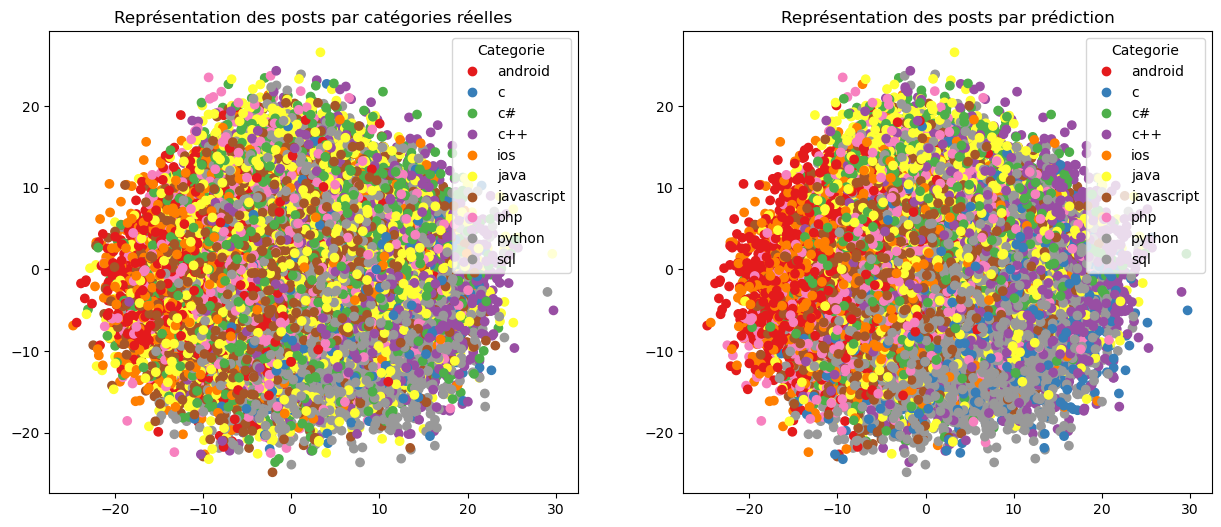

ARI :  0.1725


In [66]:
view_fct(x, dfRaw['Labels'], ypred, ari)

#### Comparaison des résultats dans un dataframe

In [67]:
dfResults = pd.DataFrame(data={'Algorithm':algoNameList,'ARI Score':algoAriList})
dfResults

,Algorithm,ARI Score
0,Bag of Word,0.3953
1,Word2Vect,0.4608
2,USE,0.6196
3,BERT,0.1712


### 4. Selection du meilleur modèle (USE) et entrainement des modèles de classification sur celui ci

In [68]:
xtrain, xtest, ytrain, ytest = train_test_split(features_USE,dfRaw['Labels'],test_size=0.2,stratify=dfRaw['Labels'],random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((26858, 512), (6715, 512), (26858,), (6715,))

In [69]:
print("Train_and_test_model ...")
x, ypred, ari, trainingScore, testScore = train_and_test_model(xtrain, ytrain, xtest, ytest)

Train_and_test_model ...
Processing Logistic Regression with fit
Processing Logistic Regression
Scores : ARI 0.6196, Accuracy on Train 0.81, Accuracy on Test 0.79


Sauvegarde des modèles entrainés

In [70]:
from joblib import dump, load

In [71]:
labels_filename = 'labelsEncoder.joblib'
scaler_filename = 'scale.joblib'
pca_filename = 'pca.joblib'
logreg_filename = 'logisticRegression.joblib'

In [72]:
dump(le, labels_filename)
dump(scaler, scaler_filename)
dump(pca, pca_filename)
dump(lr, logreg_filename)

['logisticRegression.joblib']